# Spam detektáló - MLOps vizsgamunka - Fehér Péter

##Dataset :
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

##1. Előkészítés

Első lépésként szükséges python-csomagok importálása, és két segédfüggvény definiálása:

1. `validate_data(df)`: Adatminőség ellenőrzés (nincsenek hiányzó értékek, az adatkészlet mérete legyen legalább 1000 sor, ne legyen túl sok a spam).
2. `save_metrics(metrics, filepath)`: A futás során kiszámolt metrikákat JSON-ben elmenti a megadott útvonalra, időbélyeggel.



In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (classification_report,accuracy_score,confusion_matrix,roc_auc_score,roc_curve)

In [2]:
def validate_data(df):
    if df.isnull().any().any():
        raise ValueError("Hiányzó értékek találhatók az adatban!")
    if len(df) < 1000:
        raise ValueError(f"Az adathalmaz túl kicsi: {len(df)} sor")
    spam_ratio = (df['label'] == 'spam').mean()
    if not (0.05 < spam_ratio < 0.5):
        print(f"Figyelem: szokatlan spam arány: {spam_ratio:.3f}")
    return True

def save_metrics(metrics, filepath='artifacts/training_metrics.json'):

    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    metrics['timestamp'] = datetime.now().isoformat()
    with open(filepath, 'w') as f:
        json.dump(metrics, f, indent=2)

## 2. Adat betöltése és ellenőrzés

A Kaggle-ről letöltött `spam.csv` fájl
- létezésének ellenőrzése
- featurek beolvasása
- hiányzó értékek ellenőrzése
- első 5 sor megjelenítése szerkezet ellenőrzésre


In [4]:
data_path = os.path.join('data', 'spam.csv')
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"Nem található a dataset: {data_path}. "
        "Töltsd le a 'SMS Spam Collection Dataset'-et, és helyezd a 'data/spam.csv' útvonalra."
    )

df = pd.read_csv(data_path, encoding='latin-1', usecols=['v1', 'v2'])
df.columns = ['label', 'text']

validate_data(df)

df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 3. EDA

1. **Címke-eloszlás**: Hány „ham” és hány „spam” üzenet van az adathalmazban.  
2. **Üzenethossz-eloszlás**: A „ham” és a „spam” üzenetek milyen hosszúak.  


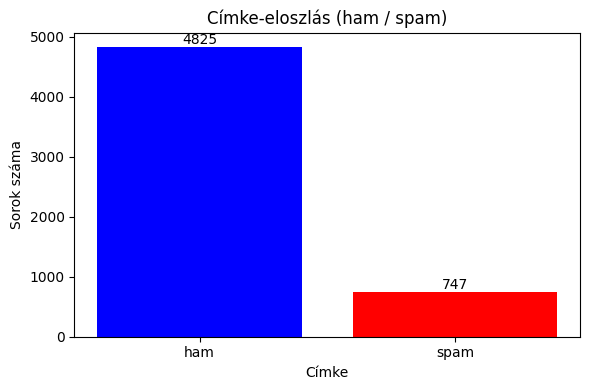

In [19]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])
plt.title('Címke-eloszlás (ham / spam)')
plt.xlabel('Címke')
plt.ylabel('Sorok száma')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 50, str(v), ha='center')
plt.tight_layout()
plt.show()


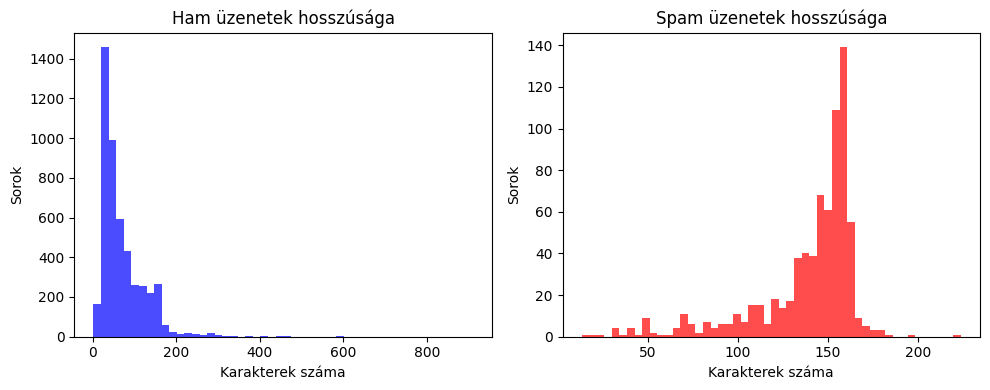

In [18]:
df['text_length'] = df['text'].apply(len)

ham_lens = df[df['label'] == 'ham']['text_length']
spam_lens = df[df['label'] == 'spam']['text_length']

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(ham_lens, bins=50, alpha=0.7, color='blue')
plt.title('Ham üzenetek hosszúsága')
plt.xlabel('Karakterek száma')
plt.ylabel('Sorok')

plt.subplot(1,2,2)
plt.hist(spam_lens, bins=50, alpha=0.7, color='red')
plt.title('Spam üzenetek hosszúsága')
plt.xlabel('Karakterek száma')
plt.ylabel('Sorok')

plt.tight_layout()
plt.show()


## 4. Label encoding és train–test split

A `label` változó numerikussá alakítása:

- `ham` → 0  
- `spam` → 1

80/20 arányban train és test felosztás, a későbbi kiértékelésre.

In [7]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

X = df['text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"Train méret: {X_train.shape[0]} sor, Test méret: {X_test.shape[0]} sor")
print("Címke-eloszlás az egész adathalmazban:")
print(df['label'].value_counts().to_string())


Train méret: 4457 sor, Test méret: 1115 sor
Címke-eloszlás az egész adathalmazban:
label
ham     4825
spam     747


## 5. Vektorizálás és modell betanítása

A szöveges adatok számszerűsítése `CountVectorizer`-el:

- `lowercase=True`: minden szöveget kisbetűssé alakít  
- `stop_words='english'`: angol stopwordokat eltávolít  
- `ngram_range=(1,1)`: csak egyes szavak használata  
- `max_features=10000`: legfeljebb 10.000 leggyakoribb szó megtartása


1. **Fit-transform a train adaton**, hogy felépüljön a szótár.  
2. **Transform a teszt adaton** ugyanazzal a vektorizálóval.  
3. `MultinomialNB(alpha=1.0)` betanítása a vektorizált train-adatokon.  


In [8]:
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    max_features=10000
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print(f"Vocabulary méret: {len(vectorizer.vocabulary_)}")
print(f"Feature matrix alakja (train): {X_train_vec.shape}")

model = MultinomialNB(alpha=1.0)
model.fit(X_train_vec, y_train)


Vocabulary méret: 7440
Feature matrix alakja (train): (4457, 7440)


MultinomialNB()

## 6. A modell kiértékelése



In [9]:
y_pred       = model.predict(X_test_vec)
y_pred_proba = model.predict_proba(X_test_vec)

accuracy  = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = classification_report(
    y_test, y_pred,
    target_names=['ham','spam'],
    output_dict=True
)

print("=== KIÉRTÉKELÉS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC:  {auc_score:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['ham','spam']))
print("Confusion Matrix:")
print(f"[[TN: {conf_matrix[0,0]}, FP: {conf_matrix[0,1]}],")
print(f" [FN: {conf_matrix[1,0]}, TP: {conf_matrix[1,1]}]]")


=== KIÉRTÉKELÉS ===
Accuracy: 0.9839
AUC-ROC:  0.9896

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.96      0.92      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[TN: 960, FP: 6],
 [FN: 12, TP: 137]]


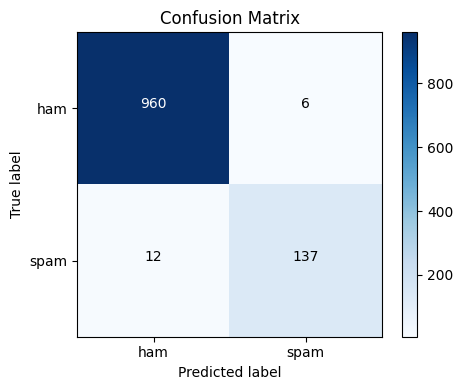

In [20]:
cm = conf_matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, str(cm[i,j]),
            ha='center',
            color='white' if cm[i,j] > thresh else 'black'
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


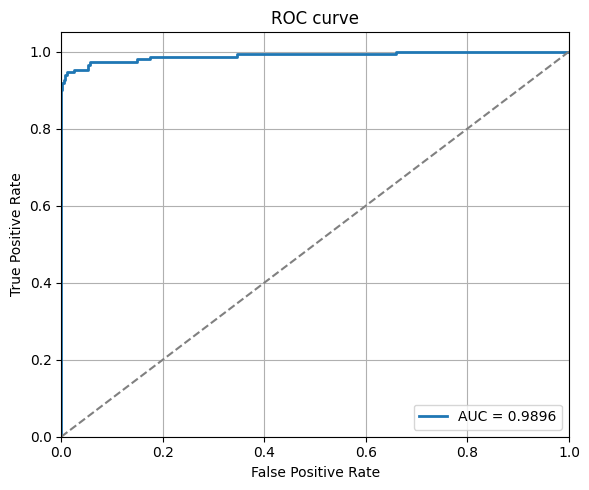

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## 7. Extra tesztesetek

In [23]:
test_messages = [
    "Congrats! You've won a $1000 Walmart gift card. Go to http://you.won.com to claim now.",
    "Hey, are we still on for dinner tonight?",
    "Free entry in 2 a weekly competition to win FA Cup final tickets. Text FA to 845. They cost 50p.",
    "Don't forget to bring your laptop tomorrow for the meeting."
]

print("=== EXTRA TESZTESETEK ===")
for msg in test_messages:
    X_sample = vectorizer.transform([msg])
    pred = model.predict(X_sample)[0]
    proba = model.predict_proba(X_sample)[0]
    label = 'spam' if pred == 1 else 'ham'
    confidence = proba[pred]
    print(f"Üzenet: \"{msg}\"\n  → Predikció: {label}, confidence: {confidence:.4f}\n")


=== EXTRA TESZTESETEK ===
Üzenet: "Congrats! You've won a $1000 Walmart gift card. Go to http://you.won.com to claim now."
  → Predikció: spam, confidence: 1.0000

Üzenet: "Hey, are we still on for dinner tonight?"
  → Predikció: ham, confidence: 0.9999

Üzenet: "Free entry in 2 a weekly competition to win FA Cup final tickets. Text FA to 845. They cost 50p."
  → Predikció: spam, confidence: 1.0000

Üzenet: "Don't forget to bring your laptop tomorrow for the meeting."
  → Predikció: ham, confidence: 1.0000



## 8. Metrikák JSON-ba mentése

A kiszámított metrikákat egy strukturált JSON-fájlba mentése (`artifacts/training_metrics.json`).
A JSON-hoz egy `timestamp` mezőt hozzáadok, hogy látszódjon, mikor futott utoljára.


In [13]:
metrics = {
    'model_version': f"v1.0_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    'accuracy': float(accuracy),
    'auc_roc': float(auc_score),
    'precision_spam': float(report_dict['spam']['precision']),
    'recall_spam': float(report_dict['spam']['recall']),
    'f1_spam': float(report_dict['spam']['f1-score']),
    'confusion_matrix': conf_matrix.tolist(),
    'train_size': int(X_train.shape[0]),
    'test_size': int(X_test.shape[0]),
    'vocabulary_size': int(len(vectorizer.vocabulary_)),
}

save_metrics(metrics)
print("Metrikák elmentve: artifacts/training_metrics.json")


Metrikák elmentve: artifacts/training_metrics.json


## 9. Modell és vektorizáló mentése

A teljesen betanított `vectorizer` és `model` objektumot egyetlen pickle-dobozba menti (`spam_model.pkl`).

A file a `artifacts/spam_model.pkl` helyre kerül mentésre.

In [24]:
os.makedirs('artifacts', exist_ok=True)
artifact_path = os.path.join('artifacts', 'spam_model.pkl')

model_data = {
    'vectorizer': vectorizer,
    'model': model,
    'metadata': {
        'trained_at': datetime.now().isoformat(),
        'accuracy': accuracy,
        'auc_roc': auc_score,
        'model_version': metrics['model_version']
    }
}

with open(artifact_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"Modell sikeresen mentve: {artifact_path}")


Modell sikeresen mentve: artifacts/spam_model.pkl
